In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import train_test_split

import warnings

warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

In [3]:
# data = pd.read_csv('/kaggle/input/rain-rain/train_df.csv')
data = pd.read_csv('train_df.csv')

pd.set_option('display.max_columns', None) 
data

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2014-05-24,Penrith,10.6,24.9,0.0,NaN,NaN,NW,20.0,SSW,NaN,4.0,0.0,68.0,47.0,NaN,NaN,NaN,NaN,16.7,23.3,No,No
1,2016-09-04,Dartmoor,6.0,15.1,1.6,NaN,NaN,NW,41.0,NNW,NW,15.0,24.0,94.0,77.0,1023.0,1024.0,NaN,NaN,10.6,13.9,Yes,No
2,2011-01-26,Moree,24.6,41.4,0.0,12.4,12.8,NE,31.0,NNE,ENE,20.0,11.0,51.0,24.0,1012.7,1009.6,0.0,1.0,30.1,39.3,No,No
3,2013-08-22,Bendigo,3.7,12.6,6.6,1.4,NaN,NW,41.0,WNW,NW,15.0,19.0,95.0,71.0,1011.3,1009.4,8.0,8.0,8.5,12.2,Yes,Yes
4,2011-10-19,Watsonia,7.6,27.9,0.0,8.0,12.5,N,54.0,NE,N,9.0,22.0,57.0,36.0,1026.6,1023.1,1.0,1.0,19.8,27.3,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99530,2016-01-12,BadgerysCreek,19.7,34.6,5.0,NaN,NaN,SE,33.0,N,ESE,7.0,19.0,65.0,53.0,1010.3,1011.1,NaN,NaN,27.0,29.2,Yes,No
99531,2012-11-23,Mildura,12.4,32.3,0.0,10.2,10.5,NE,24.0,E,E,13.0,9.0,43.0,19.0,1017.9,1014.4,4.0,6.0,21.2,29.9,No,No
99532,2014-02-19,Cobar,23.0,34.1,0.0,8.2,NaN,W,56.0,NNW,W,20.0,28.0,73.0,19.0,1002.1,999.2,7.0,1.0,25.6,33.3,No,No
99533,2015-11-09,PerthAirport,14.7,30.4,0.0,7.0,12.4,E,52.0,S,SW,13.0,30.0,58.0,40.0,1019.7,1016.0,1.0,2.0,22.6,28.1,No,No


заменим yes/no на 0/1

In [4]:
data['RainTomorrow'] = (data['RainTomorrow'] == 'Yes').astype(int)
data['RainToday'] = (data['RainToday'] == 'Yes').astype(int)

Распишем дату:

In [5]:
data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Day'] = pd.to_datetime(data['Date']).dt.day
data['Season'] = data['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                    3: 'Spring', 4: 'Spring', 5: 'Spring',
                                    6: 'Winter', 7: 'Winter', 8: 'Winter',
                                    9: 'Fall', 10: 'Fall', 11: 'Fall'})

Отсортруем по дате

In [6]:
data = data.sort_values(by='Date')

In [7]:
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday          int64
RainTomorrow       int64
Year               int32
Month              int32
Day                int32
Season            object
dtype: object

# ПРОПУСКИ

Ну, наверное заполним все пропуски во float средним для месяца и места. 

Выяснилось, что для некоторых признаков эти группы пусты, поэтому добавим это случаи грппировкой только по месяцу

In [9]:
data['MinTemp'] = data.groupby(['Location', 'Month'])['MinTemp'].transform(lambda x: x.fillna(x.mean()))
data['MaxTemp'] = data.groupby(['Location', 'Month'])['MaxTemp'].transform(lambda x: x.fillna(x.mean()))

data['Temp9am'] = data.groupby(['Location', 'Month'])['Temp9am'].transform(lambda x: x.fillna(x.mean()))
data['Temp3pm'] = data.groupby(['Location', 'Month'])['Temp3pm'].transform(lambda x: x.fillna(x.mean()))

data['Rainfall'] = data.groupby(['Location', 'Month'])['Rainfall'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Rainfall'].transform(lambda x: x.fillna(x.mean()))))

data['Evaporation'] = data.groupby(['Location', 'Month'])['Evaporation'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Evaporation'].transform(lambda x: x.fillna(x.mean()))))

data['Sunshine'] = data.groupby(['Location', 'Month'])['Sunshine'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Sunshine'].transform(lambda x: x.fillna(x.mean()))))

data['WindGustSpeed'] = data.groupby(['Location', 'Month'])['WindGustSpeed'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['WindGustSpeed'].transform(lambda x: x.fillna(x.mean()))))

data['WindSpeed9am'] = data.groupby(['Location', 'Month'])['WindSpeed9am'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['WindSpeed9am'].transform(lambda x: x.fillna(x.mean()))))
data['WindSpeed3pm'] = data.groupby(['Location', 'Month'])['WindSpeed9am'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['WindSpeed3pm'].transform(lambda x: x.fillna(x.mean()))))

data['Humidity9am'] = data.groupby(['Location', 'Month'])['Humidity9am'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Humidity9am'].transform(lambda x: x.fillna(x.mean()))))
data['Humidity3pm'] = data.groupby(['Location', 'Month'])['Humidity3pm'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Humidity3pm'].transform(lambda x: x.fillna(x.mean()))))

data['Pressure9am'] = data.groupby(['Location', 'Month'])['Pressure9am'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Pressure9am'].transform(lambda x: x.fillna(x.mean()))))
data['Pressure3pm'] = data.groupby(['Location', 'Month'])['Pressure3pm'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Pressure3pm'].transform(lambda x: x.fillna(x.mean()))))

data['Cloud9am'] = data.groupby(['Location', 'Month'])['Cloud9am'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Cloud9am'].transform(lambda x: x.fillna(x.mean()))))
data['Cloud3pm'] = data.groupby(['Location', 'Month'])['Cloud3pm'].transform(lambda x: x.fillna(x.mean() if not x.isna().all() else data.groupby(['Month'])['Cloud3pm'].transform(lambda x: x.fillna(x.mean()))))


в object сделаем тоже самое, но наверное не найденные данные лучше дропним, потому что для напрваления ветра всё-таки принципален город

In [10]:
def fill_mode(group):
    mode_value = group.mode()
    return group.fillna(mode_value.iloc[0]) if not mode_value.empty else group

# Заполняем моду (самое частое значение в группе)
data['WindGustDir'] = data.groupby(['Location', 'Month'])['WindGustDir'].transform(fill_mode)
data['WindDir9am'] = data.groupby(['Location', 'Month'])['WindDir9am'].transform(fill_mode)
data['WindDir3pm'] = data.groupby(['Location', 'Month'])['WindDir3pm'].transform(fill_mode)

# Удаляем строки, где после заполнения остались NaN
data['WindGustDir'] = data['WindGustDir'].ffill()
data['WindDir9am'] = data['WindDir9am'].ffill()
data['WindDir3pm'] = data['WindDir3pm'].ffill()
data.dropna(subset=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)

# Проверяем размер датафрейма
print(data.shape)


(99535, 27)


In [11]:
# for column in data.drop('Date', axis=1).columns:
#     plt.figure(figsize=(16, 16))
#     sns.histplot(data[column], kde=True, color='red')
#     plt.title(f'{column}')
#     plt.xlabel(column)
#     plt.ylabel('Частота')
#     plt.show()

# ФИЧИ

осадки за последние 3 дня и за последнюю неделю

In [13]:
data['Rainfall_Last_3'] = data['Rainfall'].rolling(window=3, min_periods=1).sum()
data['Rainfall_Last_7'] = data['Rainfall'].rolling(window=7, min_periods=1).sum()

И был ли дождь вчера

In [14]:
data['RainYesterday'] = data.groupby('Location')['RainToday'].shift(1)
data['RainYesterday'] = data['RainYesterday'].ffill()
data.dropna(subset=['RainYesterday'], inplace=True)
data['RainYesterday'] = data['RainYesterday'].astype('int')

добавим лаги, чтобы следить изменение давленеия и влажности (одни из самых важных признаков)

по итогу влияет только то, что было вчера, остальное не сильно улучшает предсказания (или даже ухудашет)

но цикл останется, только будет от 1 до 2 :)

In [16]:
df=data.copy()
for i in range(1,2):
    col = f'Pressure3pm_prev_{i}_day'
    df[col]=df.groupby('Location')['Pressure3pm'].shift(i) 
    df[col] = df[col].ffill()
    df.dropna(subset=[col], inplace=True)

    col_spike = f'Pressure3pmSpike _{i}'
    df[col_spike] = round(df['Pressure3pm']-df[col], 2)
    df = df.drop(columns=[col])
    
data = df.copy()

In [17]:
df=data.copy()
for i in range(1,2):
    col = f'Humidity3pm_prev_{i}_day'
    df[col]=df.groupby('Location')['Humidity3pm'].shift(i) 
    df[col] = df[col].ffill()
    df.dropna(subset=[col], inplace=True)

    col_spike = f'Humidity3pmSpike _{i}'
    df[col_spike] = df['Humidity3pm']-df[col]
    df = df.drop(columns=[col])
    
data = df.copy()
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,Season,Rainfall_Last_3,Rainfall_Last_7,RainYesterday,Pressure3pmSpike _1,Humidity3pmSpike _1
21820,2007-11-06,Canberra,6.2,16.9,0.0,5.800000,8.200000,SE,44.000000,SE,E,20.0,20.0,70.0,57.0,1023.8,1021.7,7.000000,5.00000,10.9,14.8,0,0,2007,11,6,Fall,42.6,46.2,1,3.2,8.0
61529,2007-11-07,Canberra,6.1,18.2,0.2,4.200000,8.400000,SE,43.000000,SE,ESE,19.0,19.0,63.0,47.0,1024.6,1022.2,4.000000,6.00000,12.4,17.3,0,0,2007,11,7,Fall,3.0,46.4,0,0.5,-10.0
54691,2007-11-09,Canberra,8.8,19.5,0.0,4.000000,4.100000,S,48.000000,E,ENE,19.0,19.0,70.0,48.0,1026.1,1022.7,7.000000,7.00000,14.1,18.9,0,1,2007,11,9,Fall,0.2,46.4,0,0.5,1.0
75088,2007-11-10,Canberra,8.4,22.8,16.2,5.400000,7.700000,E,31.000000,S,ESE,7.0,7.0,82.0,32.0,1024.1,1020.7,7.000000,1.00000,13.3,21.7,1,0,2007,11,10,Fall,16.4,62.6,0,-2.0,-16.0
30888,2007-11-11,Canberra,9.1,25.2,0.0,4.200000,11.900000,N,30.000000,SE,NW,6.0,6.0,74.0,34.0,1024.4,1021.1,1.000000,2.00000,14.6,24.0,0,0,2007,11,11,Fall,16.2,59.0,1,0.4,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99185,2017-06-25,Moree,6.7,22.2,0.0,3.071831,6.783465,W,19.000000,E,W,9.0,9.0,73.0,31.0,1021.0,1017.7,5.000000,4.36129,11.4,21.7,0,0,2017,6,25,Winter,0.4,4.2,0,-5.1,-9.0
40509,2017-06-25,Sale,0.1,14.8,0.0,1.231193,4.623853,W,35.391813,WNW,NW,6.0,6.0,72.0,50.0,1016.3,1013.2,5.197531,5.05988,5.9,14.0,0,0,2017,6,25,Winter,0.4,0.4,1,-3.2,-9.0
43161,2017-06-25,MelbourneAirport,5.5,13.9,0.0,2.800000,3.800000,NNW,44.000000,N,NW,26.0,26.0,72.0,58.0,1017.8,1015.5,7.000000,7.00000,8.1,12.2,0,0,2017,6,25,Winter,0.0,0.4,1,-2.0,8.0
63930,2017-06-25,Cobar,9.1,22.0,0.0,1.961728,6.333333,W,28.000000,NE,WNW,15.0,15.0,62.0,33.0,1020.2,1017.4,1.000000,3.00000,13.0,20.8,0,0,2017,6,25,Winter,0.0,0.4,0,-1.6,4.0


shift(1...8)
max_streak

как ощущается температура (по сложной формуле)

In [18]:
def feels_like(temp_9am, temp_3pm, humidity_9am, humidity_3pm, wind_speed_9am, wind_speed_3pm):
    temp = (temp_9am + temp_3pm) / 2
    humidity = (humidity_9am + humidity_3pm) / 2
    wind_speed = (wind_speed_9am + wind_speed_3pm) / 2
    
    if (temp_9am >= 27 or temp_3pm >= 27)  and (humidity_9am  >= 80 or humidity_3pm  >= 80):  #индекс жары: HI = −8.7847 + 1.6114T + 2.3385H − 0.1461TH − 0.0123T^2 − 0.0164H^2 + 0.0022T^2H + 0.0007TH^2 − 0.0003T^2H^2
        hi = (-8.7847 + 1.6114 * temp + 2.3385 * humidity - 0.1461 * temp * humidity
              - 0.0123 * temp ** 2 - 0.0164 * humidity ** 2
              + 0.0022 * temp ** 2 * humidity + 0.0007 * temp * humidity ** 2
              - 0.0003 * temp ** 2 * humidity ** 2)
        return round(hi, 2)
    
    elif (temp_9am <= 10 or temp_3pm <= 10) and (wind_speed_9am >= 4.8 or wind_speed_3pm >= 4.8):  # охлаждение ветром: WC = 13.12 + 0.6215T − 11.37V^0.16  + 0.3965TV^0.16
        wc = (13.12 + 0.6215 * temp - 11.37 * (wind_speed ** 0.16)
              + 0.3965 * temp * (wind_speed ** 0.16))
        return round(wc, 2)
    
    return round(temp, 2)

data['Feels_like'] = data.apply(lambda row: feels_like(row['Temp9am'], row['Temp3pm'], row['Humidity9am'], row['Humidity3pm'], row['WindSpeed9am'], row['WindSpeed3pm']), axis=1)

фактор облаков = осуствие облаков * солнце

In [19]:
df = data.copy()

#cloud: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0
#sunshine: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0

df['Сloud_factor'] = (1 - (data['Cloud9am'] + data['Cloud3pm']) / 20) * (data['Sunshine'] / 15)  # 0 — пасмурно, 1 — солнечно
data['Cloud_factor'] = pd.qcut(df['Сloud_factor'], 5, labels=False)  

попробуем добавиьт широту и долготу

In [55]:
def add_coordinates(df):
    # Словарь координат: 'Город': (Широта, Долгота)
    coordinates = {
        'Canberra': (-35.2809, 149.1300),
        'Sydney': (-33.8688, 151.2093),
        'Brisbane': (-27.4698, 153.0251),
        'Darwin': (-12.4634, 130.8456),
        'Adelaide': (-34.9285, 138.6007),
        'Hobart': (-42.8821, 147.3272),
        'Perth': (-31.9505, 115.8605),
        'Melbourne': (-37.8136, 144.9631),
        'Bendigo': (-36.7587, 144.2820),
        'MountGambier': (-37.8318, 140.7820),
        'AliceSprings': (-23.6980, 133.8807),
        'Townsville': (-19.2589, 146.8169),
        'Cairns': (-16.9186, 145.7781),
        'Newcastle': (-32.9283, 151.7817),
        'GoldCoast': (-28.0167, 153.4000),
        'Launceston': (-41.4388, 147.1340),
        'Penrith': (-33.7513, 150.6949),
        'Albury': (-36.0737, 146.9135),
        'MountGinini': (-35.5281, 148.7725),
        'Tuggeranong': (-35.4167, 149.0833),
        'Ballarat': (-37.5622, 143.8503),
        'Wollongong': (-34.4278, 150.8931),
        'Albany': (-35.0270, 117.8840),
        'NorfolkIsland': (-29.0408, 167.9547),
        'PerthAirport': (-31.9403, 115.9661),
        'Woomera': (-31.1983, 136.8250),
        'NorahHead': (-33.2810, 151.5760),
        'SydneyAirport': (-33.9399, 151.1753),
        'Richmond': (-33.6000, 150.7500),
        'SalmonGums': (-32.9810, 121.6350),
        'Witchcliffe': (-34.0240, 115.1000),
        'Cobar': (-31.4980, 145.8380),
        'Watsonia': (-37.7160, 145.0830),
        'MelbourneAirport': (-37.6690, 144.8410),
        'WaggaWagga': (-35.1180, 147.3670),
        'CoffsHarbour': (-30.2963, 153.1135),
        'Moree': (-29.4615, 149.8410),
        'BadgerysCreek': (-33.8690, 150.7770),
        'Sale': (-38.1080, 147.0630),
        'Portland': (-38.3496, 141.6050),
        'Nuriootpa': (-34.4680, 138.9960),
        'Mildura': (-34.1855, 142.1625),
        'PearceRAAF': (-31.6670, 116.0170),
        'Williamtown': (-32.7910, 151.8340),
        'Walpole': (-34.9790, 116.7330),
        'Dartmoor': (-37.9170, 141.2670),
        'Katherine': (-14.4650, 132.2630),
        'Nhil': (-36.3330, 141.6500),
        'Uluru': (-25.3444, 131.0369),
    }

    # Присваиваем широту и долготу по Location
    df['Latitude'] = df['Location'].apply(lambda x: coordinates.get(x, (None, None))[0])
    df['Longitude'] = df['Location'].apply(lambda x: coordinates.get(x, (None, None))[1])
    
    return df

In [56]:
data = add_coordinates(data)

определим регион

In [20]:
australian_regions = {
    "Southeast": [
        "Canberra", "Sydney", "Melbourne", "Bendigo", "Albury", "Wollongong", 
        "NorahHead", "Penrith", "Ballarat", "Watsonia", "Sale", "MelbourneAirport",
        "SydneyAirport", "BadgerysCreek"
    ],
    "South": [
        "Hobart", "Adelaide", "MountGambier", "Dartmoor", "Portland", 
        "Mildura", "Nuriootpa", "WaggaWagga"
    ],
    "East": [
        "Brisbane", "GoldCoast", "Cairns", "Townsville", "CoffsHarbour",
        "Moree", "Richmond"
    ],
    "West": [
        "Perth", "PerthAirport", "Witchcliffe", "SalmonGums", "Walpole",
        "PearceRAAF"
    ],
    "North": [
        "Darwin", "Katherine"
    ],
    "Central": [
        "AliceSprings", "Uluru"
    ],
    "Remote": [
        "Tuggeranong", "MountGinini", "Woomera", "NorfolkIsland", "Cobar", "Nhil", "Williamtown"
    ]
}

def get_region(location):
    for region, cities in australian_regions.items():
        if location in cities:
            return region
    return "Unknown"

data['Region'] = data['Location'].apply(get_region)

добавим ещё зависимоть регоина и сезона

In [21]:
data['Region_Season'] = data['Region'] + '_' + data['Season']

отдельно отметим изменния температуры и давления перед дождем

In [22]:
# data['Temp_Drop_Flag'] = (data['Temp9am'] > data['Temp3pm']).astype(int) # 1 - температура упала
data['Pressure_Drop_Flag'] = (data['Pressure9am'] > data['Pressure3pm']).astype(int) # 1  - давление упало

температура не сильно важный признка, пока уберём

Добавим ещё генереализацию: среднее количесвто осдаков за месяц и количество дождей

In [24]:
data['AvgRainfall'] = data.groupby(['Location', 'Month'])['Rainfall'].transform('mean')
data['RainsCount'] = data.groupby(['Location', 'Month'])['RainToday'].transform('sum')

In [26]:
data['TomorrowHum'] = data.groupby('Location')['Humidity3pm'].shift(-1) # Потму что она важнее, чем Humidity9am
data['TomorrowHum'] = data['TomorrowHum'].ffill()

# data['TomorrowPres'] = data.groupby('Location')['Pressure3pm'].shift(-1) # Потму что она важнее
# data['TomorrowPres'] = data['TomorrowPres'].ffill()

In [27]:
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,Season,Rainfall_Last_3,Rainfall_Last_7,RainYesterday,Pressure3pmSpike _1,Humidity3pmSpike _1,Feels_like,Cloud_factor,Region,Region_Season,Pressure_Drop_Flag,AvgRainfall,RainsCount,TomorrowHum,TomorrowPres
21820,2007-11-06,Canberra,6.2,16.9,0.0,5.800000,8.200000,SE,44.000000,SE,E,20.0,20.0,70.0,57.0,1023.8,1021.7,7.000000,5.00000,10.9,14.8,0,0,2007,11,6,Fall,42.6,46.2,1,3.2,8.0,12.85,1,Southeast,Southeast_Fall,1,2.145024,46,47.0,1022.2
61529,2007-11-07,Canberra,6.1,18.2,0.2,4.200000,8.400000,SE,43.000000,SE,ESE,19.0,19.0,63.0,47.0,1024.6,1022.2,4.000000,6.00000,12.4,17.3,0,0,2007,11,7,Fall,3.0,46.4,0,0.5,-10.0,14.85,2,Southeast,Southeast_Fall,1,2.145024,46,48.0,1022.7
54691,2007-11-09,Canberra,8.8,19.5,0.0,4.000000,4.100000,S,48.000000,E,ENE,19.0,19.0,70.0,48.0,1026.1,1022.7,7.000000,7.00000,14.1,18.9,0,1,2007,11,9,Fall,0.2,46.4,0,0.5,1.0,16.50,0,Southeast,Southeast_Fall,1,2.145024,46,32.0,1020.7
75088,2007-11-10,Canberra,8.4,22.8,16.2,5.400000,7.700000,E,31.000000,S,ESE,7.0,7.0,82.0,32.0,1024.1,1020.7,7.000000,1.00000,13.3,21.7,1,0,2007,11,10,Fall,16.4,62.6,0,-2.0,-16.0,17.50,2,Southeast,Southeast_Fall,1,2.145024,46,34.0,1021.1
30888,2007-11-11,Canberra,9.1,25.2,0.0,4.200000,11.900000,N,30.000000,SE,NW,6.0,6.0,74.0,34.0,1024.4,1021.1,1.000000,2.00000,14.6,24.0,0,0,2007,11,11,Fall,16.2,59.0,1,0.4,2.0,19.30,4,Southeast,Southeast_Fall,1,2.145024,46,35.0,1019.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99185,2017-06-25,Moree,6.7,22.2,0.0,3.071831,6.783465,W,19.000000,E,W,9.0,9.0,73.0,31.0,1021.0,1017.7,5.000000,4.36129,11.4,21.7,0,0,2017,6,25,Winter,0.4,4.2,0,-5.1,-9.0,16.55,2,East,East_Winter,1,1.418235,21,49.0,1016.0
40509,2017-06-25,Sale,0.1,14.8,0.0,1.231193,4.623853,W,35.391813,WNW,NW,6.0,6.0,72.0,50.0,1016.3,1013.2,5.197531,5.05988,5.9,14.0,0,0,2017,6,25,Winter,0.4,0.4,1,-3.2,-9.0,9.41,1,Southeast,Southeast_Winter,1,1.960204,43,49.0,1016.0
43161,2017-06-25,MelbourneAirport,5.5,13.9,0.0,2.800000,3.800000,NNW,44.000000,N,NW,26.0,26.0,72.0,58.0,1017.8,1015.5,7.000000,7.00000,8.1,12.2,0,0,2017,6,25,Winter,0.0,0.4,1,-2.0,8.0,7.06,0,Southeast,Southeast_Winter,1,1.845304,50,49.0,1016.0
63930,2017-06-25,Cobar,9.1,22.0,0.0,1.961728,6.333333,W,28.000000,NE,WNW,15.0,15.0,62.0,33.0,1020.2,1017.4,1.000000,3.00000,13.0,20.8,0,0,2017,6,25,Winter,0.0,0.4,0,-1.6,4.0,16.90,3,Remote,Remote_Winter,1,1.829319,36,49.0,1016.0


In [28]:
print(data.isnull().sum())
print(data.shape)
data = data.drop_duplicates()
print(data.shape)

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
WindGustDir            0
WindGustSpeed          0
WindDir9am             0
WindDir3pm             0
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am            0
Pressure3pm            0
Cloud9am               0
Cloud3pm               0
Temp9am                0
Temp3pm                0
RainToday              0
RainTomorrow           0
Year                   0
Month                  0
Day                    0
Season                 0
Rainfall_Last_3        0
Rainfall_Last_7        0
RainYesterday          0
Pressure3pmSpike _1    0
Humidity3pmSpike _1    0
Feels_like             0
Cloud_factor           0
Region                 0
Region_Season          0
Pressure_Drop_Flag     0
AvgRainfall            0
RainsCount             0
TomorrowHum            0


Здесь я хотела применить get dummies для всех категорий, но это не сильно помогло (лучше не стало, но работает дольше), но пусть будет как закоменченная идея

In [120]:
# cf = [
#     'Location',
#     'WindGustDir',
#      'WindDir9am',
#     'WindDir3pm',
#    	'RainToday',
#     'Year',	
#     'Month',
#     'Day',
#     'Season',
#     'Cloud_factor',
#     'Region',
#     # 'WindDirDiff',
#     # 'Temp_Drop_Flag',       
#     'Pressure_Drop_Flag',
#     'Region_Season',
#     # 'Cloud_factor_prev_day',
#     'RainYesterday'
# ]

# data_dummy = pd.get_dummies(data, columns=cf, drop_first=False)
# data_dummy

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow,Rainfall_Last_3,Rainfall_Last_7,Pressure3pmSpike _1,Humidity3pmSpike _1,Feels_like,AvgRainfall,RainsCount,TomorrowHum,Location_Adelaide,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_0,RainToday_1,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Season_Fall,Season_Spring,Season_Winter,Cloud_factor_0,Cloud_factor_1,Cloud_factor_2,Cloud_factor_3,Cloud_factor_4,Region_Central,Region_East,Region_North,Region_Remote,Region_South,Region_Southeast,Region_Unknown,Region_West,Pressure_Drop_Flag_0,Pressure_Drop_Flag_1,Region_Season_Central_Fall,Region_Season_Central_Spring,Region_Season_Central_Winter,Region_Season_East_Fall,Region_Season_East_Spring,Region_Season_East_Winter,Region_Season_North_Fall,Region_Season_North_Spring,Region_Season_North_Winter,Region_Season_Remote_Fall,Region_Season_Remote_Spring,Region_Season_Remote_Winter,Region_Season_South_Fall,Region_Season_South_Spring,Region_Season_South_Winter,Region_Season_Southeast_Fall,Region_Season_Southeast_Spring,Region_Season_Southeast_Winter,Region_Season_Unknown_Fall,Region_Season_Unknown_Spring,Region_Season_Unknown_Winter,Region_Season_West_Fall,Region_Season_West_Spring,Region_Season_West_Winter,RainYesterday_0,RainYesterday_1
21820,2007-11-06,6.2,16.9,0.0,5.800000,8.200000,44.000000,20.0,20.0,70.0,57.0,1023.8,1021.7,7.000000,5.00000,10.9,14.8,0,42.6,46.2,3.2,8.0,12.85,2.145024,46,47.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [28]:
# cf_dummy = data_dummy.columns.difference(data.columns).tolist()
# cf_dummy

['Cloud_factor_0',
 'Cloud_factor_1',
 'Cloud_factor_2',
 'Cloud_factor_3',
 'Cloud_factor_4',
 'Day_1',
 'Day_10',
 'Day_11',
 'Day_12',
 'Day_13',
 'Day_14',
 'Day_15',
 'Day_16',
 'Day_17',
 'Day_18',
 'Day_19',
 'Day_2',
 'Day_20',
 'Day_21',
 'Day_22',
 'Day_23',
 'Day_24',
 'Day_25',
 'Day_26',
 'Day_27',
 'Day_28',
 'Day_29',
 'Day_3',
 'Day_30',
 'Day_31',
 'Day_4',
 'Day_5',
 'Day_6',
 'Day_7',
 'Day_8',
 'Day_9',
 'Location_Adelaide',
 'Location_Albury',
 'Location_AliceSprings',
 'Location_BadgerysCreek',
 'Location_Ballarat',
 'Location_Bendigo',
 'Location_Brisbane',
 'Location_Cairns',
 'Location_Canberra',
 'Location_Cobar',
 'Location_CoffsHarbour',
 'Location_Dartmoor',
 'Location_Darwin',
 'Location_GoldCoast',
 'Location_Hobart',
 'Location_Katherine',
 'Location_Launceston',
 'Location_Melbourne',
 'Location_MelbourneAirport',
 'Location_Mildura',
 'Location_Moree',
 'Location_MountGambier',
 'Location_MountGinini',
 'Location_Nhil',
 'Location_NorahHead',
 'Locatio

# CatBoost 🙀

In [29]:
cf = (
    'Location',
    'WindGustDir',
    'WindDir9am',
    'WindDir3pm',
   	'RainToday',
    'Year',	
    'Month',
    'Day',
    'Season',
    'Cloud_factor',
    'Region',
    # 'WindDirDiff',
    # 'Temp_Drop_Flag',       
    'Pressure_Drop_Flag',
    'Region_Season',
    # 'Cloud_factor_prev_day',
    'RainYesterday'
)

Попробуем предсказать осадки на завтра через регрессию 

In [65]:
data_main, data_reg = train_test_split(data, test_size=0.3, shuffle=False, random_state=42)

In [66]:
X_hum = data_reg.drop(columns=['RainTomorrow', 'Date', 'TomorrowHum'])
y_hum = data_reg['TomorrowHum']

X_hum_train, X_hum_test, y_hum_train, y_hum_test = train_test_split(X_hum, y_hum, test_size=0.1, shuffle=False,  random_state=42)

model_hum =CatBoostRegressor(
    iterations=16_000, 
    depth=6, 
    learning_rate=0.05, 
    cat_features=cf, 
    verbose=100, 
    early_stopping_rounds=100,
    eval_metric = 'RMSE',
    loss_function = 'RMSE',
)

model_hum.fit(X_hum_train, y_hum_train, eval_set=(X_hum_test, y_hum_test), verbose=100)

y_pred_hum = model_hum.predict(X_hum_test)

print('RMSE', np.sqrt(mean_squared_error(y_hum_test, y_pred_hum)))

0:	learn: 20.3723387	test: 18.3512318	best: 18.3512318 (0)	total: 37.2ms	remaining: 9m 55s
100:	learn: 14.0828384	test: 12.9471664	best: 12.9469857 (99)	total: 3.31s	remaining: 8m 40s
200:	learn: 13.6476032	test: 12.8614093	best: 12.8614093 (200)	total: 6.62s	remaining: 8m 40s
300:	learn: 13.3558570	test: 12.8479394	best: 12.8428284 (253)	total: 9.87s	remaining: 8m 34s
400:	learn: 13.1480886	test: 12.8382746	best: 12.8382746 (400)	total: 13.9s	remaining: 9m 1s
500:	learn: 12.9832087	test: 12.8245761	best: 12.8225673 (497)	total: 17.3s	remaining: 8m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12.82256727
bestIteration = 497

Shrink model to first 498 iterations.
RMSE 12.822567268070888


In [68]:
print("R² pres:", model_hum.score(X_hum_test, y_hum_test))

R² pres: 0.5167396900926526


Очень даже неплохо

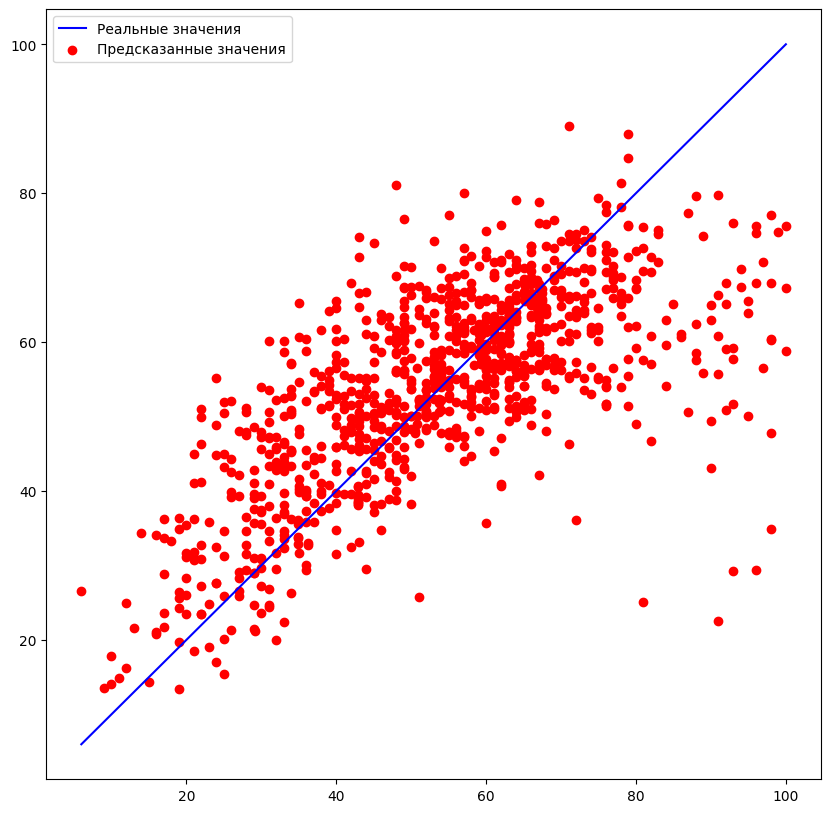

In [75]:
sample_indices = np.random.choice(len(y_pred_hum), size=1000, replace=False)
y_test_sample = np.array(y_hum_test)[sample_indices]
y_pred_sample = np.array(y_pred_hum)[sample_indices]
plt.figure(figsize=(10,10))
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_hum_test), max(y_hum_test)],  color='blue', label='Реальные значения')
plt.scatter(y_test_sample, y_pred_sample, color='red', label='Предсказанные значения')
plt.legend()
plt.show()

In [69]:
X1 = data_main.drop(columns=['RainTomorrow', 'Date'])
y1 = data_main['RainTomorrow']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=False,  random_state=42)

model1 = CatBoostClassifier (
    iterations=5_000,
    depth=7,
    learning_rate=0.05,
    verbose=100, 
    early_stopping_rounds=500, 
    cat_features = cf,
    l2_leaf_reg=3,
    # custom_metric='TotalF1'
)

model1.fit(X1_train, y1_train, eval_set=(X1_test, y1_test), verbose=100)

#Предсказываем для тестовой выборки  влажность
X1_test = X1_test.drop('TomorrowHum', axis=1)
X1_test_pool_hum = Pool(X1_test, cat_features=cf)
X1_test['TomorrowHum'] = model_hum.predict(X1_test_pool_hum)

y1_pred = model1.predict(X1_test)
  
print(classification_report(y1_test, y1_pred))

0:	learn: 0.6545197	test: 0.6523798	best: 0.6523798 (0)	total: 108ms	remaining: 8m 57s
100:	learn: 0.3190177	test: 0.3201994	best: 0.3201994 (100)	total: 10.4s	remaining: 8m 23s
200:	learn: 0.2964656	test: 0.3107784	best: 0.3107784 (200)	total: 20.6s	remaining: 8m 10s
300:	learn: 0.2788281	test: 0.3053185	best: 0.3053045 (299)	total: 31.3s	remaining: 8m 8s
400:	learn: 0.2655519	test: 0.3027525	best: 0.3027294 (399)	total: 41.5s	remaining: 7m 56s
500:	learn: 0.2552502	test: 0.3015488	best: 0.3015488 (500)	total: 51.8s	remaining: 7m 44s
600:	learn: 0.2467721	test: 0.3007222	best: 0.3007222 (600)	total: 1m 2s	remaining: 7m 37s
700:	learn: 0.2387239	test: 0.3001236	best: 0.3001219 (699)	total: 1m 12s	remaining: 7m 26s
800:	learn: 0.2309393	test: 0.2998597	best: 0.2998396 (799)	total: 1m 23s	remaining: 7m 15s
900:	learn: 0.2242462	test: 0.2993761	best: 0.2993640 (899)	total: 1m 33s	remaining: 7m 7s
1000:	learn: 0.2173052	test: 0.2992296	best: 0.2991132 (990)	total: 1m 44s	remaining: 6m 56s


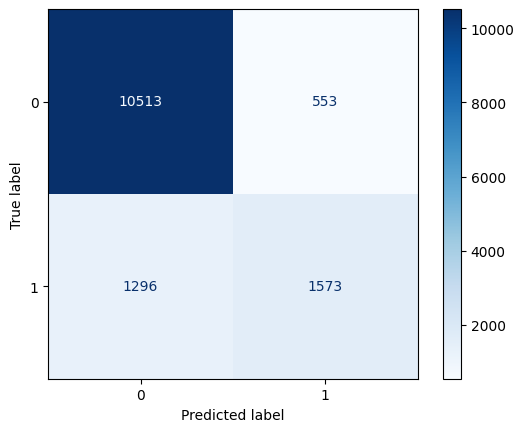

In [45]:
cm = confusion_matrix(y1_test, y1_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot(cmap='Blues')
plt.show()

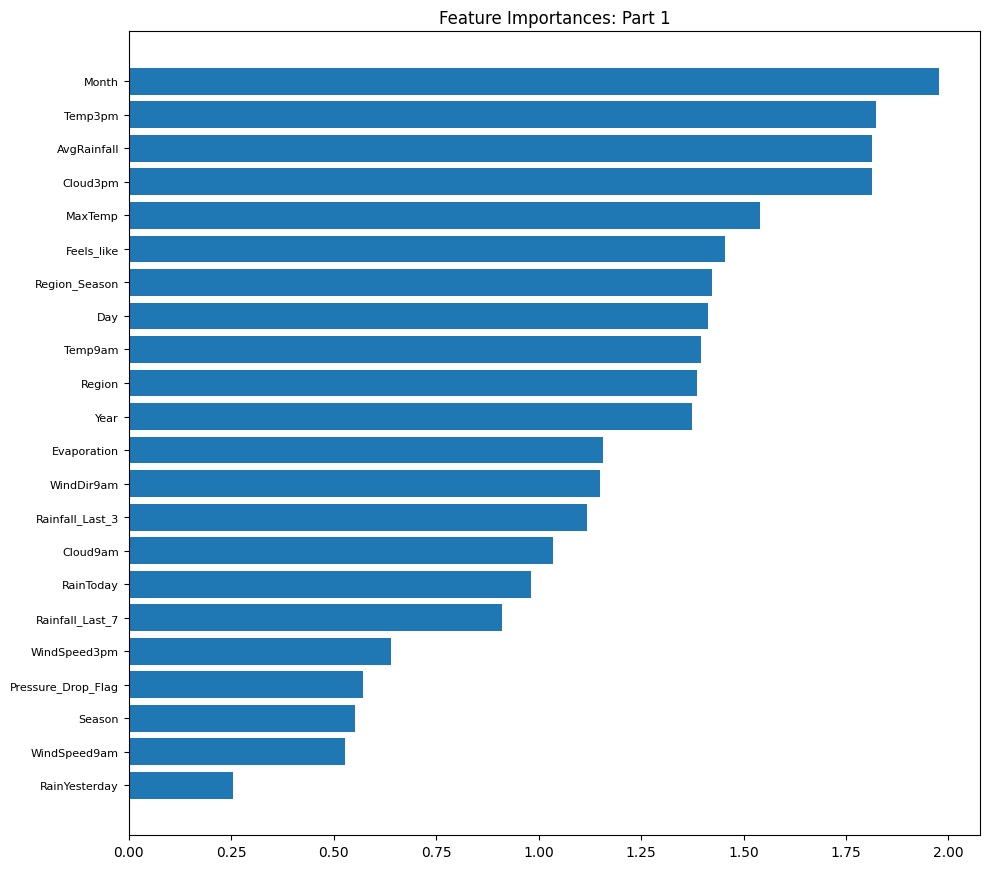

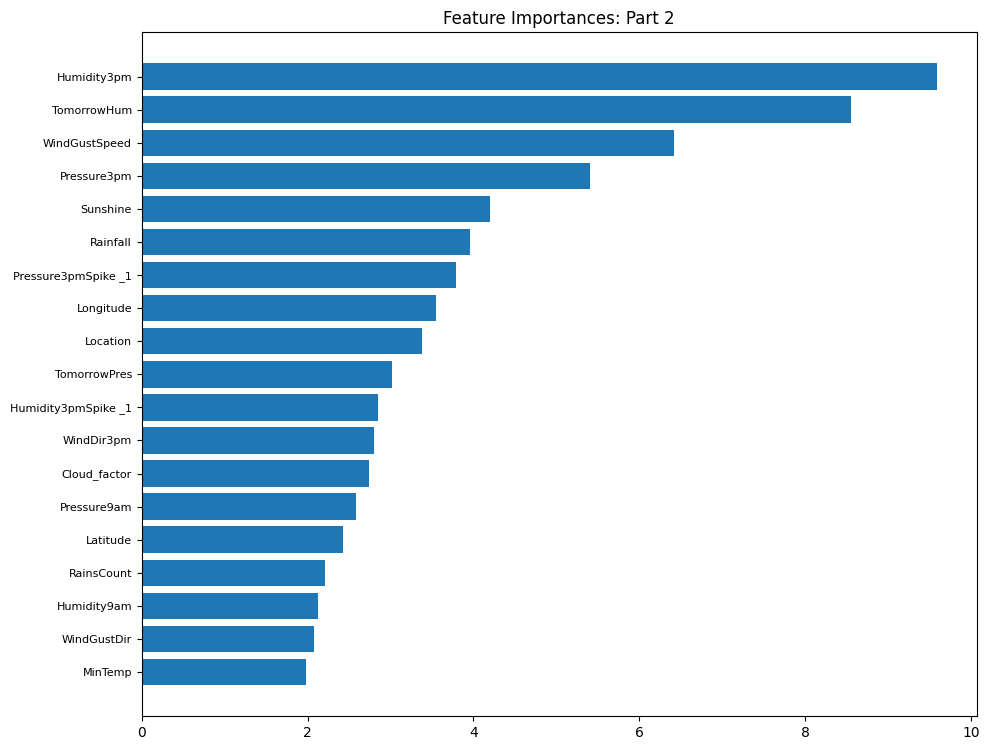

Humidity3pm: 9.5928
TomorrowHum: 8.5540
WindGustSpeed: 6.4229
Pressure3pm: 5.4111
Sunshine: 4.2044
Rainfall: 3.9544
Pressure3pmSpike _1: 3.7883
Longitude: 3.5453
Location: 3.3782
TomorrowPres: 3.0243
Humidity3pmSpike _1: 2.8483
WindDir3pm: 2.8042
Cloud_factor: 2.7400
Pressure9am: 2.5874
Latitude: 2.4259
RainsCount: 2.2150
Humidity9am: 2.1252
WindGustDir: 2.0823
MinTemp: 1.9787
Month: 1.9781
Temp3pm: 1.8244
AvgRainfall: 1.8138
Cloud3pm: 1.8130
MaxTemp: 1.5400
Feels_like: 1.4536
Region_Season: 1.4230
Day: 1.4145
Temp9am: 1.3970
Region: 1.3873
Year: 1.3737
Evaporation: 1.1583
WindDir9am: 1.1498
Rainfall_Last_3: 1.1182
Cloud9am: 1.0343
RainToday: 0.9809
Rainfall_Last_7: 0.9116
WindSpeed3pm: 0.6407
Pressure_Drop_Flag: 0.5709
Season: 0.5511
WindSpeed9am: 0.5277
RainYesterday: 0.2555


In [73]:
importances = model1.feature_importances_
indices = np.argsort(importances)
features = np.array(X1.columns)[indices]
importances_sorted = importances[indices]

features_per_plot = 22
n_plots = int(np.ceil(len(features) / features_per_plot))

for i in range(n_plots):
    start = i * features_per_plot
    end = min(start + features_per_plot, len(features))
    current_len = end - start

    fig, ax = plt.subplots(figsize=(10, current_len * 0.4))

    ax.barh(range(current_len), importances_sorted[start:end])
    ax.set_yticks(range(current_len))
    ax.set_yticklabels(features[start:end], fontsize=8)
    ax.set_title(f'Feature Importances: Part {i+1}')
    plt.tight_layout()
    plt.show()

for feature, importance in zip(features[::-1], importances_sorted[::-1]):
    print(f'{feature}: {importance:.4f}')


# Catboost для dummy

# Мета модель

Есть предположение, что модель немного пепреобучается